In [1]:
import warnings
warnings.filterwarnings("ignore") 

import pysm3 as pysm
import pysm3.units as u
import numpy as np
import healpy as hp 
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.io.fits as fits

mpl.rcParams['font.sans-serif'] = "Helvetica"
plt.style.use('default')

#### version check for libraries used here

In [2]:
print(pysm.__version__, np.__version__, hp.__version__, mpl.__version__)

3.4.0b6 1.23.5 1.16.2 3.6.3


#### Define HEALPix parameters

In [3]:
nside = 1024
npix = hp.nside2npix(nside)
lmax = 3 * nside - 1 

hpx_datapath = '/Users/shamik/opt/Healpix_3.81/data'

#### Input LFI 30 GHz average bandpass

Text(0.5, 1.0, 'LFI 30GHz average RIMO bandpass')

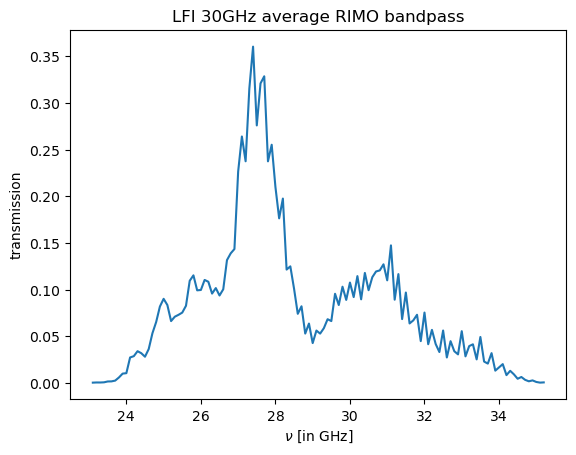

In [4]:
RIMO_file = '../resources/LFI_RIMO_R3.31.fits'
hdul = fits.open(RIMO_file)

band = '030'

nus_in_GHz = hdul['BANDPASS_'+band].data['WAVENUMBER']
transmission = hdul['BANDPASS_'+band].data['TRANSMISSION']

nus_in_GHz = nus_in_GHz[transmission>0.001*np.max(transmission)]
transmission = transmission[transmission>0.001*np.max(transmission)]

# transmission /= np.trapz(transmission, x=nus_in_GHz*con.giga)
nus_in_GHz = np.array(nus_in_GHz, dtype=np.float64)
transmission = np.array(transmission,dtype=np.float64)

plt.plot(nus_in_GHz, transmission)
plt.xlabel(r'$\nu$ [in GHz]')
plt.ylabel('transmission')
plt.title('LFI 30GHz average RIMO bandpass')

#### Compute LFI 30 GHz bandpass integrated PySM synchrotron map for model s5

In [5]:
# Based on PySM3 bandpass integration tutorial: https://pysm3.readthedocs.io/en/latest/bandpass_integration.html

# Not normalizing the bandpass weights as PySM3 should normalize weights using utils.normalize_bandpass

sync_5_bpi = pysm.Sky(nside=nside, preset_strings=["s5"])
syncmap_5_bpi = sync_5_bpi.get_emission(nus_in_GHz * u.GHz, transmission)

# Unit conversion factor uK_RJ to uK_CMB assuming bandpass weights (not in the above tutorial)
UC = pysm.bandpass_unit_conversion(nus_in_GHz*u.GHz, weights=transmission, output_unit=u.uK_CMB, input_unit=u.uK_RJ, cut=1e-10)

# Convert units and smooth to 33.1 arcmin resolution of LFI 30GHz
syncmap_5_bpi = syncmap_5_bpi * UC
syncmap_5_bpi = hp.smoothing(syncmap_5_bpi, fwhm=np.deg2rad(33.1/60.), use_weights=True, datapath=hpx_datapath)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


#### Compute 30 GHz maps without bandpass integration for model s5

In [6]:
# Get single frequency 30GHz map for model s5
f = 30. # GHz
sync_5_sf = pysm.Sky(nside=nside, preset_strings=["s5"])
syncmap_5_sf = sync_5_sf.get_emission(f * u.GHz)

# Convert units to uK_CMB and smooth the map to 33.1 arcmin resolution
syncmap_5_sf = syncmap_5_sf.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(f*u.GHz))
syncmap_5_sf = hp.smoothing(syncmap_5_sf, fwhm=np.deg2rad(33.1/60.), use_weights=True, datapath=hpx_datapath)

#### projview the maps

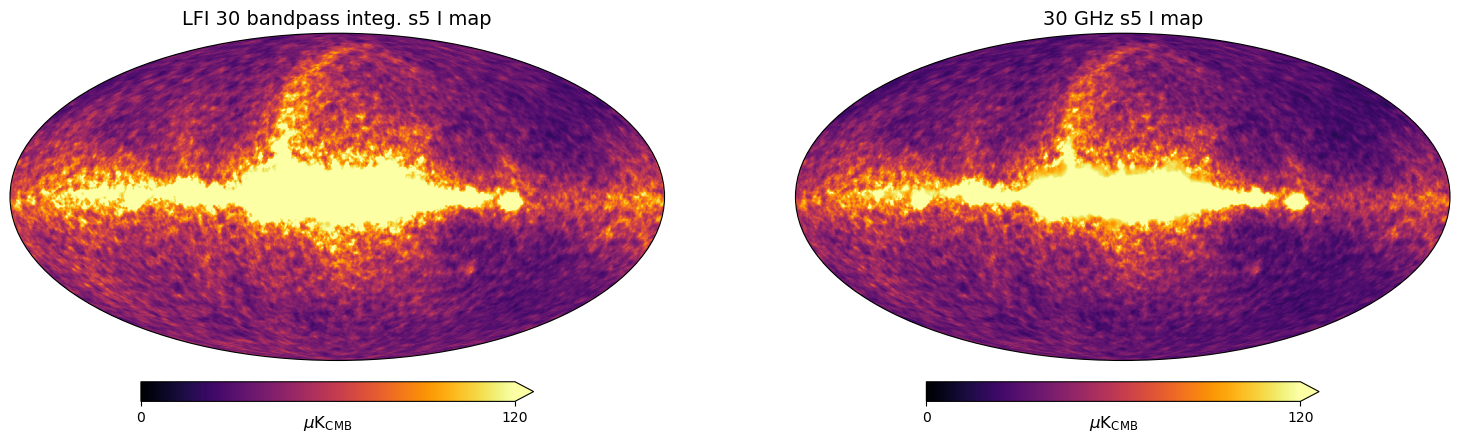

In [13]:
hp.projview(m=syncmap_5_bpi[0], unit=r'$\mu$K${}_{\rm CMB}$', xsize=2000, width=15., sub=121, min=0., max=120, cmap='inferno', graticule=False, projection_type='mollweide', 
title='LFI 30 bandpass integ. s5 I map', graticule_color=None)
hp.projview(m=syncmap_5_sf[0], unit=r'$\mu$K${}_{\rm CMB}$', xsize=2000, width=15., sub=122, min=0., max=120, cmap='inferno', graticule=False, projection_type='mollweide', 
title='30 GHz s5 I map', graticule_color=None)

In [11]:
polI_5_bpi = np.sqrt(syncmap_5_bpi[1]**2. + syncmap_5_bpi[2]**2.)
polI_5_sf = np.sqrt(syncmap_5_sf[1]**2. + syncmap_5_sf[2]**2.)

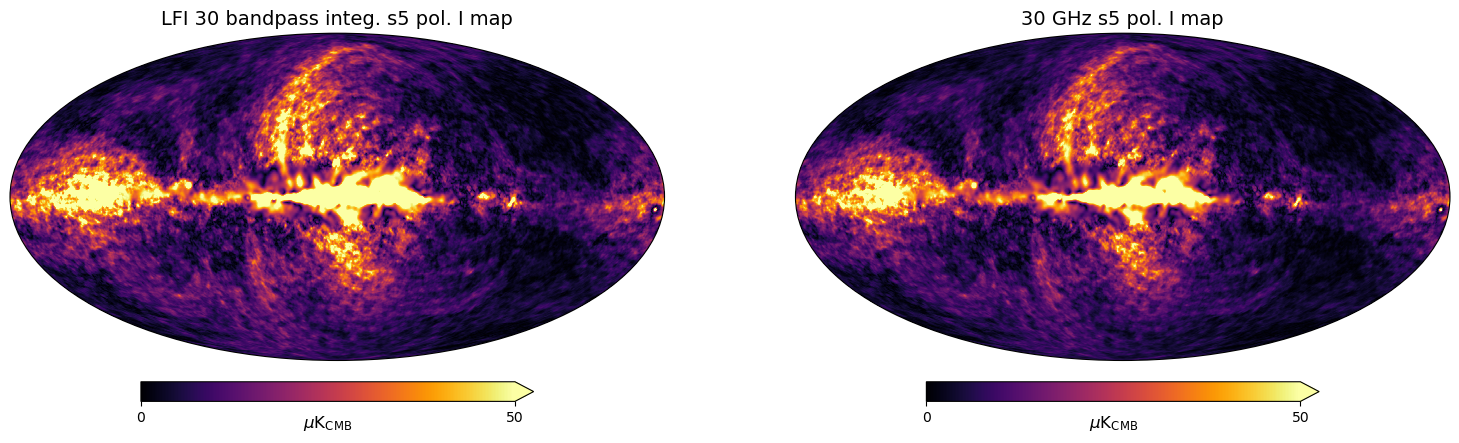

In [15]:
hp.projview(m=polI_5_bpi, unit=r'$\mu$K${}_{\rm CMB}$', xsize=2000, width=15., sub=121, min=0., max=50, cmap='inferno', graticule=False, projection_type='mollweide', 
title='LFI 30 bandpass integ. s5 pol. I map', graticule_color=None)
hp.projview(m=polI_5_sf, unit=r'$\mu$K${}_{\rm CMB}$',xsize=2000, width=15., sub=122, min=0., max=50, cmap='inferno', graticule=False, projection_type='mollweide', 
title='30 GHz s5 pol. I map', graticule_color=None)